In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import networkx as nx
import random
import pandas as pd
#import tensorflow as tf
#Disable TensorFlow 2 behaviour
from sklearn.model_selection import KFold  
from sklearn.preprocessing import StandardScaler 
from sklearn import preprocessing
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import os
from sklearn.metrics import mean_squared_error
from CASTLE import CASTLE
from utils import random_dag, gen_data_nonlinear
from signal import signal, SIGINT
from sys import exit
import argparse

Instructions for updating:
non-resource variables are not supported in the long term


C:\Users\brizio\AppData\Roaming\Python\Python37\site-packages\networkx\drawing\layout.py:950: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


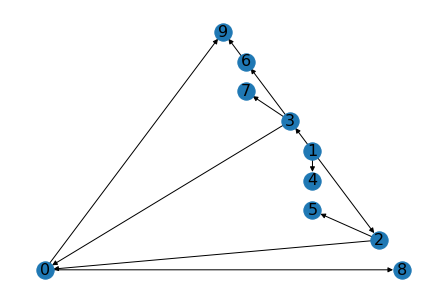

In [2]:
dataset_sz = 5000
csv = "synth_nonlinear.csv"
df = pd.read_csv(csv)
df_test = df.iloc[-1000:]
df = df.iloc[:dataset_sz]


G = nx.DiGraph()
for i in range(10):
    G.add_node(i)
G.add_edge(1,2)
G.add_edge(1,3)
G.add_edge(1,4)
G.add_edge(2,5)
G.add_edge(2,0)
G.add_edge(3,0)
G.add_edge(3,6)
G.add_edge(3,7)
G.add_edge(6,9)
G.add_edge(0,8)
G.add_edge(0,9)
G

pos=nx.planar_layout(G)
nx.draw(G,pos)
labels={}
for i in range(10):
    labels[i] = i
nx.draw_networkx_labels(G,pos,labels,font_size=16);

In [3]:
# df['0'] = [int(i > .5) for i in preprocessing.scale(df['0'])]

In [4]:
df['0'].describe()

count    5000.000000
mean        2.490209
std         1.213778
min        -1.437822
25%         1.689177
50%         2.426209
75%         3.205960
max        13.763755
Name: 0, dtype: float64

In [5]:
# G = random_dag(23, 50)
# G

In [6]:
random_data = False
if random_data:
    G = random_dag(23, 50)
    # G
    def handler(signal_received, frame):
        # Handle any cleanup here
        print('SIGINT or CTRL-C detected. Exiting gracefully')
        exit(0)
    def str2bool(v):
        if isinstance(v, bool):
           return v
        if v.lower() in ('yes', 'true', 't', 'y', '1'):
            return True
        elif v.lower() in ('no', 'false', 'f', 'n', '0'):
            return False
        else:
            raise argparse.ArgumentTypeError('Boolean value expected.') 

    # noise = random.uniform(0.3, 1.0)
    # print("Setting noise to ", noise)
    # df = gen_data_nonlinear(G, SIZE = dataset_sz, var = noise).iloc[:dataset_sz]
    # df_test =  gen_data_nonlinear(G, SIZE = int(dataset_sz*0.25), var = noise)
    # df

    def swap_cols(df, a, b):
        df = df.rename(columns = {a : 'temp'})
        df = df.rename(columns = {b : a})
        return df.rename(columns = {'temp' : b})
    def swap_nodes(G, a, b):
        newG = nx.relabel_nodes(G, {a : 'temp'})
        newG = nx.relabel_nodes(newG, {b : a})
        return nx.relabel_nodes(newG, {'temp' : b})

    for i in range(len(G.edges())):
        if len(list(G.predecessors(i))) > 0:
            df = swap_cols(df, str(0), str(i))
            df_test = swap_cols(df_test, str(0), str(i))
            G = swap_nodes(G, 0, i)
            break      

    #print("Number of parents of G", len(list(G.predecessors(i))))
    print("Edges = ", list(G.edges()))

In [7]:
scaler = StandardScaler()
n_folds = 10
df = scaler.fit_transform(df)
df_test = scaler.transform(df_test)

X_test = df_test
y_test = df_test[:,0]
X_DAG = df

kf = KFold(n_splits = n_folds, random_state = 1, shuffle = True)

print("Dataset limits are", np.ptp(X_DAG), np.ptp(X_test), np.ptp(y_test))


Dataset limits are 22.43824804096758 14.264787433454547 12.751701336069463


In [8]:
    reg_lambda = 1
    reg_beta = 5

    fold = 0
    REG_castle = []
    print("Dataset limits are", np.ptp(X_DAG), np.ptp(X_test), np.ptp(y_test))
    for train_idx, val_idx in kf.split(X_DAG):
        fold += 1
        print("fold = ", fold)
        print("******* Doing dataset size = ", dataset_sz , "****************")
        X_train = X_DAG[train_idx]
        y_train = np.expand_dims(X_DAG[train_idx][:,0], -1)
        X_val = X_DAG[val_idx]
        y_val = X_DAG[val_idx][:,0]

        w_threshold = 0.3
        castle = CASTLE(num_train = X_DAG.shape[0], num_inputs = X_DAG.shape[1], reg_lambda = reg_lambda, reg_beta = reg_beta,
                            w_threshold = w_threshold)
        num_nodes = np.shape(X_DAG)[1]
        castle.fit(X_train, y_train, num_nodes, X_val, y_val, X_test, y_test)
        W_est = castle.pred_W(X_DAG, np.expand_dims(X_DAG[:,0], -1))
        print(W_est)

        REG_castle.append(mean_squared_error(castle.pred(X_test), y_test))
        print("MSE = ", mean_squared_error(castle.pred(X_test), y_test))

        if fold > 1:
            print(np.mean(REG_castle), np.std(REG_castle))


Dataset limits are 22.43824804096758 14.264787433454547 12.751701336069463
fold =  1
******* Doing dataset size =  5000 ****************
Step 1, Loss= 1.9437  h_value: 0.0005245209
Step 2, Loss= 0.7286  h_value: 0.00029850006
Step 3, Loss= 0.7263  h_value: 0.00018501282
Step 4, Loss= 0.7095  h_value: 0.00013065338
Step 5, Loss= 0.7297  h_value: 0.000166893
Step 6, Loss= 0.7092  h_value: 0.00015544891
Step 7, Loss= 0.7069  h_value: 0.00014686584
Step 8, Loss= 0.6903  h_value: 0.00020313263
Step 9, Loss= 0.7003  h_value: 0.00016212463
Step 10, Loss= 0.6993  h_value: 0.0001411438
Step 11, Loss= 0.6923  h_value: 0.0001487732
Step 12, Loss= 0.6891  h_value: 0.00018501282
Step 13, Loss= 0.6775  h_value: 0.00019741058
Step 14, Loss= 0.6952  h_value: 0.0002040863
Step 15, Loss= 0.6898  h_value: 0.00020980835
Step 16, Loss= 0.6978  h_value: 0.00019550323
Step 17, Loss= 0.6906  h_value: 0.00018692017
Step 18, Loss= 0.6804  h_value: 0.00022125244
Step 19, Loss= 0.6832  h_value: 0.0002708435
Step 

In [12]:
print(pd.DataFrame(REG_castle))
print("Mean= ","{:.3}".format(np.mean(REG_castle)),", Sd= ","{:.3}".format(np.std(REG_castle)))

          0
0  0.635888
1  0.682855
2  0.649542
3  0.681774
4  0.625513
5  0.690044
6  0.630766
7  0.657666
8  0.655078
9  0.627007
Mean=  0.654 , Sd=  0.0231


In [13]:
run_full = False
if run_full:
    scaler = StandardScaler()
    n_folds = 10
    df = scaler.fit_transform(df)
    df_test = scaler.transform(df_test)

    X_test = df_test
    y_test = df_test[:,0]
    X_DAG = df
    y_DAG = np.expand_dims(X_DAG[:,0], -1)

    castle.fit(X_DAG, y_DAG, num_nodes, X_test, y_test, X_test, y_test)


In [14]:
import numpy as np
import seaborn as sns
import pandas as pd

intersection_matrix = castle.get_weights(X_train, y_train)
cm = sns.light_palette("#003E74", as_cmap=True)
x=pd.DataFrame(intersection_matrix).round(3)
x=x.style.background_gradient(cmap=cm, low=-0.1, high=0.01).format("{:.3}")
display(x)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.002,0.017,0.021,0.005,0.045,0.035,0.007,0.053,0.055
1,0.008,0.0,0.072,0.061,0.07,0.005,0.011,0.008,0.004,0.007
2,0.095,0.036,0.0,0.031,0.027,0.139,0.009,0.005,0.011,0.008
3,0.071,0.04,0.031,0.0,0.035,0.003,0.108,0.109,0.011,0.007
4,0.013,0.045,0.022,0.027,0.0,0.008,0.011,0.004,0.007,0.005
5,0.039,0.003,0.022,0.006,0.005,0.0,0.009,0.007,0.003,0.014
6,0.038,0.004,0.007,0.011,0.007,0.01,0.0,0.023,0.003,0.163
7,0.024,0.006,0.004,0.01,0.003,0.022,0.028,0.0,0.009,0.009
8,0.026,0.004,0.006,0.002,0.009,0.004,0.015,0.005,0.0,0.014
9,0.026,0.004,0.004,0.005,0.004,0.008,0.073,0.004,0.007,0.0


C:\Users\brizio\AppData\Roaming\Python\Python37\site-packages\networkx\drawing\layout.py:950: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


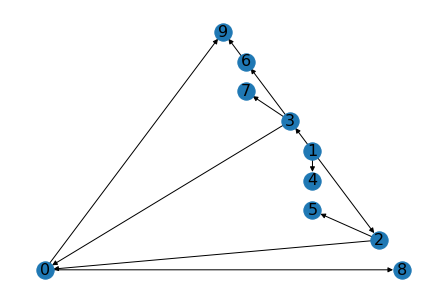

In [15]:
pos=nx.planar_layout(G)
nx.draw(G,pos)
labels={}
for i in range(10):
    labels[i] = i
nx.draw_networkx_labels(G,pos,labels,font_size=16);

In [ ]:
G1 = nx.from_numpy_matrix(intersection_matrix)

In [ ]:
pos=nx.circular_layout(G1)
nx.draw(G1,pos=pos)
labels={}
for i in range(10):
    labels[i] = i
nx.draw_networkx_labels(G,pos,labels,font_size=16);